In [1]:
import cv2

import numpy as np 
from matplotlib import pyplot as plt

In [10]:
def show_img(img_mtx: np.ndarray, in_gray: bool=False, is_show: bool=True, is_off_axis: bool=True):
    '''
        cmap='gray': display the image in grayscale
    '''
    
    if in_gray:
        plt.imshow(img_mtx, cmap='gray')
    else:
        plt.imshow(img_mtx)

    if is_off_axis:
        plt.axis('off')
 
    if is_show:
        plt.show()


def show_two_img(img_mtx1: np.ndarray, img_mtx2: np.ndarray, figsize: tuple=(8, 12)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    show_img(img_mtx1, is_show=False)

    plt.subplot(1, 2, 2)
    show_img(img_mtx2, is_show=False)

    plt.tight_layout() # fit into the figure area without overlapping
    plt.show()

In [95]:
img_path = 'materials/imgs/parrot_noisy.png'

In [96]:
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

- Написать программу, которая выполняет фильтрацию изображения изкочастотным, высокочастотным и нелинейным медианным фильтром

- Реализовать адаптивный медианный фильтр

### Linear filters

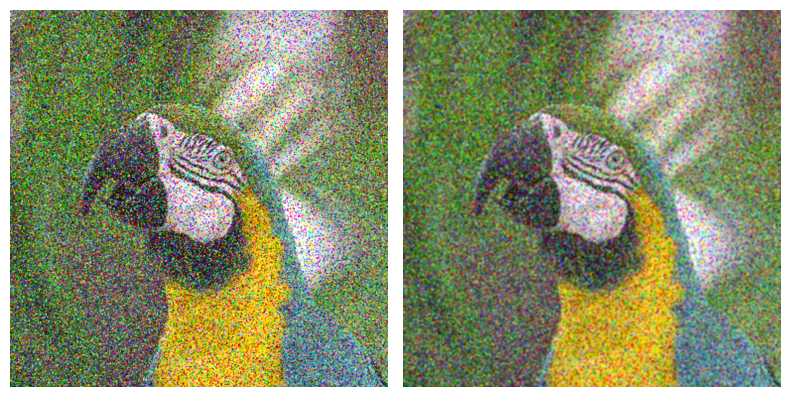

In [97]:
''' ~~~~~~~ AVERAGE SMOOTHING OR MEAN FILTERING ~~~~~~~
This technique involves replacing each pixel's value with the average 
of its neighboring pixel values within a defined kernel size
'''

img_boxed = cv2.boxFilter(
    img, 
    -1,     # -1 to keep for output image the same depth as the source image (how many bits are used to represent each pixel in the image)
    (7, 7)  # the size of the kernel (filter)
)

show_two_img(img, img_boxed)

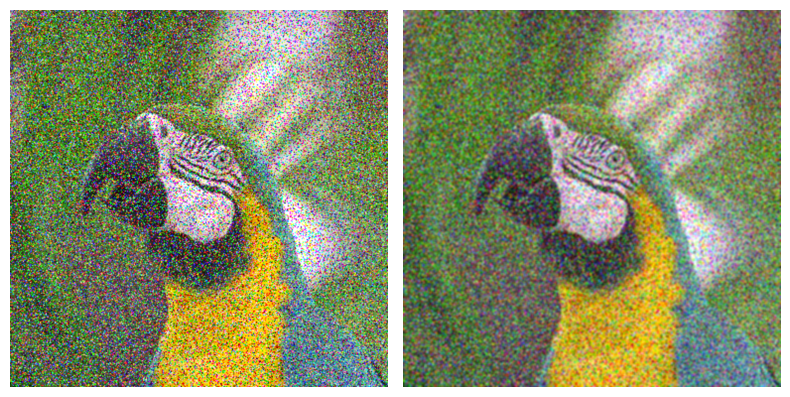

In [89]:
''' ~~~~~~~ GAUSSIAN BLUR ~~~~~~~
a mathematical function based on the Gaussian distribution, 
which gives more weight to pixels near the center of a kernel 
while diminishing the influence of those further away.

 - Small σ (e.g., 0.5):
    The kernel will be narrow and have high values at the center, leading to less blurring and more preservation of edges.
- Large σ (e.g., 3):
    The kernel will be wider, allowing more distant pixels to contribute to the new pixel value, resulting in more blurring.
'''

img_gaussianed = cv2.GaussianBlur(
    img, 
    (9, 9),     # the size of the kernel (filter)
    5           # standard deviation (σ) - (affects how much influence surrounding pixels have on the central pixel during the blurring process)
)

show_two_img(img, img_gaussianed)

### Non-linear filters

In [90]:
class CustomBlur:
    @staticmethod
    def median_blur_rgb_slower(img_mtx, ksize):
        ''' SAME AS median_blur_rgb BUT SLOWER'''
        # Step 1: Check if the ksize in odd
        if ksize % 2 == 0:
            raise ValueError('The kernel can only be an odd size')
        
        # Step 2: Calculate half the kernel size
        neighborhood_count = ksize // 2

        # Step 3: Prepare output array with the same shape as input
        blured_img_mtx = np.empty_like(img_mtx)

        # Step 4: Iterate over each pixel in the original image
        for i in range(img_mtx.shape[0]):
            for j in range(img_mtx.shape[1]):
                # - Prepare neighborhoods array with the same shape as input
                neighborhoods = np.empty((0, 3))

                # - Interate over each pixel in filter kernel
                for i_kernel in range(i-neighborhood_count, i+neighborhood_count+1):
                    if 0 <= i_kernel < img_mtx.shape[0]:
                        for j_kernel in range(j-neighborhood_count, j+neighborhood_count+1):
                            if 0 <= j_kernel < img_mtx.shape[1] and ((i_kernel != i) or (j_kernel != j)):
                                # - If current pixel indexes in array when append to current neighborhoods array 
                                neighborhoods = np.append(neighborhoods, img_mtx[i_kernel][j_kernel].reshape(1, -1), axis=0)

                # - Culculate median value for current pixel
                blured_img_mtx[i][j] = np.median(neighborhoods, axis=0)


        return blured_img_mtx


    @classmethod
    def __get_median_of_neighbors(cls, padded_img, i, j, ksize):
        # - Extract the neighborhood for each channel (flatten for convert array to one dimention array)
        #   NOTE: padded_img matrix i/j element is like i-ksize/j-ksize element for img_mtx. That's
        #         why finally the neighborhoods are all element upper and lefter then current element.
        #         We get all filter matrix involved element in center which should't be sorted
        neighborhood_r = padded_img[i:i + ksize, j:j + ksize, 0].flatten()  # Red channel
        neighborhood_g = padded_img[i:i + ksize, j:j + ksize, 1].flatten()  # Green channel
        neighborhood_b = padded_img[i:i + ksize, j:j + ksize, 2].flatten()  # Blue channel
        
        # - Check if neighborhoods are empty
        if neighborhood_r.size == 0 or neighborhood_g.size == 0 or neighborhood_b.size == 0:
            raise ValueError("Neighborhood is empty; check kernel size and image dimensions.")

        # - Calculate median using np.partition for efficiency
        #   NOTE: we sort elements relatively of center because it shouldn't be in sorting.
        #         Finally we get truly center index (in sorted neighborhoods array) which is in median
        median_r = np.partition(neighborhood_r, len(neighborhood_r) // 2)[len(neighborhood_r) // 2]
        median_g = np.partition(neighborhood_g, len(neighborhood_g) // 2)[len(neighborhood_g) // 2]
        median_b = np.partition(neighborhood_b, len(neighborhood_b) // 2)[len(neighborhood_b) // 2]

        return median_r, median_g, median_b
    

    @classmethod
    def __get_padded_img_for_rgb(clt, img_mtx, ksize):
        # Calculate half the kernel size
        half_k = ksize // 2

        # Pad the image edges for accessing neighboring pixels without going out of bounds
        # NOTE: finally we get array with refer array elements in center and extra elements
        #       on up, down, left and right sides or default elements
        padded_img = np.pad(
            img_mtx,                    # array for padding
            pad_width=(
                (half_k, half_k),       # 1D (height) of img: count of rows of padding at the top and the bottom
                (half_k, half_k),       # 2D (weight) of img: count of columns of padding at the left and the right
                (0, 0)                  # 3D (RGB) of img: no additional layers for colors channels
            ), 
            mode='edge'                 # values for padding going to taking from edge values of the origin array
        )

        return padded_img



    @staticmethod
    def median_blur_rgb(img_mtx, ksize):
        # Step 1: Check if the ksize in odd
        if ksize % 2 == 0:
            raise ValueError('The kernel can only be an odd size')

        # Step 2: Get padded image
        padded_img = CustomBlur.__get_padded_img_for_rgb(img_mtx, ksize)
        
        # Step 3: Prepare output array with the same shape as input
        blured_img_mtx = np.empty_like(img_mtx)

        # Step 4: Iterate over each pixel in the original image
        for i in range(img_mtx.shape[0]):
            for j in range(img_mtx.shape[1]):
                # - Calculate medians
                median_r, median_g, median_b = CustomBlur.__get_median_of_neighbors(padded_img, i, j, ksize)

                # - Assign median values to the output image
                blured_img_mtx[i, j] = [median_r, median_g, median_b]

        return blured_img_mtx
    


    @staticmethod
    def adaptive_median_blue(img_mtx, threshold=10, max_ksize=11):
        # Step 1: Define variables
        paddeds = {}
        median_pixels_count = 0
        default_pixels_count = 0
        
        # Step 2: Get padded image for default ksize
        ksize = 3
        paddeds[ksize] = CustomBlur.__get_padded_img_for_rgb(img_mtx, ksize)
        
        # Step 3: Prepare output array with the same shape as input
        blured_img_mtx = np.empty_like(img_mtx)
    
        # Step 4: Iterate over each pixel in the original image
        for i in range(img_mtx.shape[0]):
            for j in range(img_mtx.shape[1]):

                # - Iterate over each ksize before 
                for current_ksize in range(ksize, max_ksize+1, 2):
                    # - Get padded_img for current_ksize
                    if paddeds.get(current_ksize) is None:
                        paddeds[current_ksize] = CustomBlur.__get_padded_img_for_rgb(img_mtx, current_ksize)
                    
                    # - Calculate medians
                    rgb_medians = CustomBlur.__get_median_of_neighbors(paddeds[current_ksize], i, j, ksize)
                    rgb_medians = np.array(rgb_medians)

                    if np.mean(np.abs(img_mtx[i][j] - rgb_medians)) < threshold:
                        # - Assign median values to the output image
                        blured_img_mtx[i, j] = img_mtx[i][j]
                        default_pixels_count += 1
                        break
                else:
                    # - Assign median values to the output image
                    blured_img_mtx[i, j] = rgb_medians
                    median_pixels_count += 1

        return blured_img_mtx, median_pixels_count, default_pixels_count

    

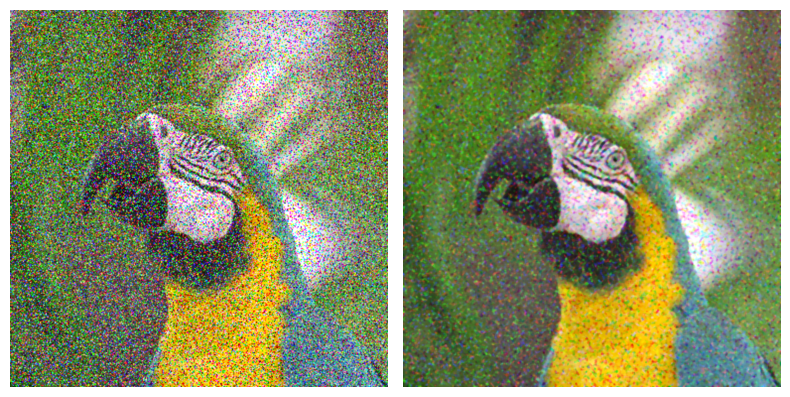

In [91]:
''' ~~~~~~~ MEADIAN FILTERATION ~~~~~~~
It replaces each pixel's value with the median value of the intensities in its neighborhood
'''
img_medianed = cv2.medianBlur(img, 9)

show_two_img(img, img_medianed)

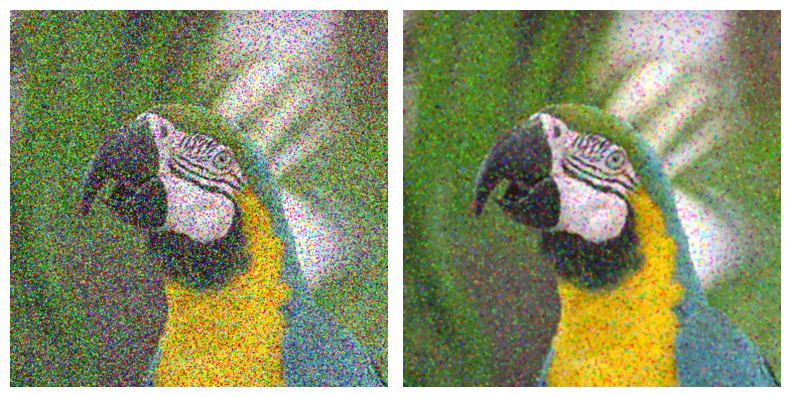

In [92]:
''' ~~~~~~~ CUSTOM SLOW MEADIAN FILTERATION ~~~~~~~ '''

img_custom_slow_medianed = CustomBlur.median_blur_rgb_slower(img, 9)

show_two_img(img, img_custom_slow_medianed)

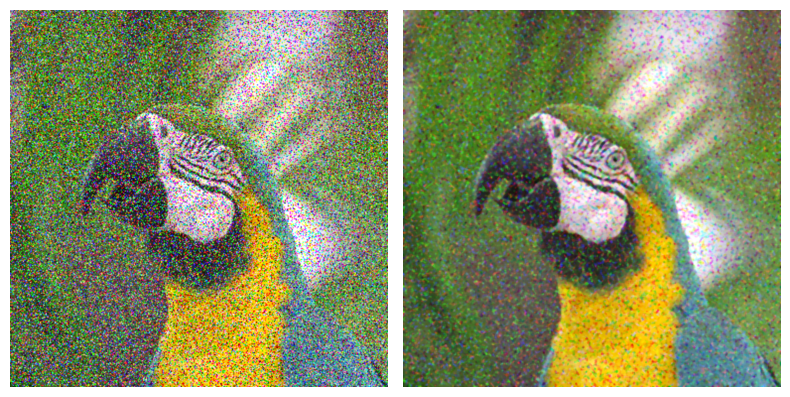

In [93]:
''' ~~~~~~~ CUSTOM MEADIAN FILTERATION ~~~~~~~ '''

img_custom_medianed = CustomBlur.median_blur_rgb(img, 9)

show_two_img(img, img_custom_medianed)

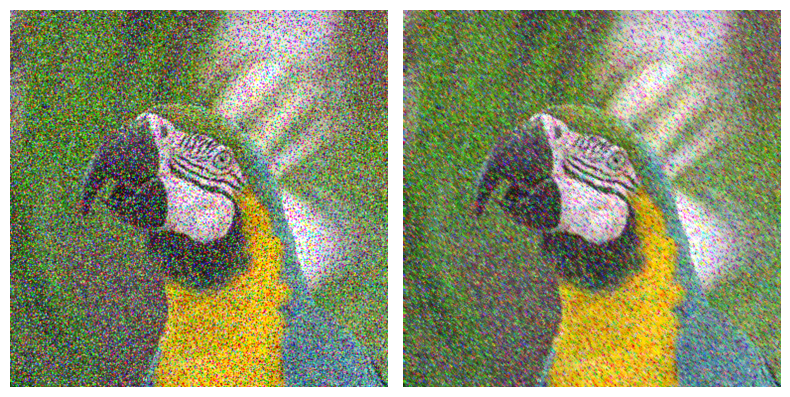

In [94]:
''' ~~~~~~~ ADAPTIVE CUSTOM MEADIAN FILTERATION ~~~~~~~ '''

img_custom_adaptive_medianed, median_pixels_count, default_pixels_count = CustomBlur.adaptive_median_blue(img)

show_two_img(img, img_custom_adaptive_medianed)